# LB Probing Techniques - Don't Overfit! II - 2nd Place Solution
If this kernel, we discuss efficient strategies to probe the Kaggle leaderboard (LB) to gain information about the public test dataset. LR Logistic regression, SVC support vector classifiation, and LDA naive Bayes, are three methods that find linear hyperplanes to classify data. In "Don't Overfit II" competition, the public test dataset has 8 times more data than the training dataset. Instead of finding the hyperplane that classifies the training data, we would prefer to find the hyperplane that classifies the public test dataset. We can. Let's assume

$$\text{target} = \text{HeavySide}(a_0x_0+a_1x_1+...a_{298}x_{298}+a_{299}x_{299}+\text{noise})$$  

Our task is to determine the 300 hyperplane coefficients `a_k`. Assuming the `a_k` are independent, then the following code extracts them from the public test dataset via LB probing:

    var = 33
    test = pd.read_csv('test.csv')
    sub = pd.read_csv('sample_submission.csv')
    sub['target'] = test[str(var)]
    sub.to_csv('submission'+str(var)+'.csv',index=False) 
   
![image](http://playagricola.com/Kaggle/sub33.jpg)

Then the value of `a_k` is the just `LB_SCORE_K` minus 0.500. For example  
  
$$a_{33} = \text{LB_SCORE}_{33} - 0.500 = 0.671 - 0.500 = 0.171 $$

When a variable is negatively correlated with target (as opposed to positively correlated), then the `LB_SCORE_K` will be less than 0.500.
  
![image](http://playagricola.com/Kaggle/sub217.jpg)

$$a_{217} = \text{LB_SCORE}_{217} - 0.500 = 0.382 - 0.500 = -0.118 $$
  
It's that simple! By doing this, we can recover the `a_k` in 20 days (100 submissions) with the following 3 additional tricks:
* Only probe the 100 most important `a_k`. If `abs(CV_SCORE_K - 0.5) < 0.04` set `a_k=0` and don't probe.
* Use train data plus public for more accuracy. Replace `LB_SCORE_K` with `(8/9)*LB_SCORE_K + (1/9)*CV_SCORE_K`.
* Apply L1-penalty. If `abs(LB_SCORE_K - 0.5) < 0.04` then set `a_k=0`.  
  
These additional tricks help prevent overfitting LB. Instead of modeling only the public test dataset and risk overfitting, we use information from both the training data plus public test data for a combined sample size of 2225. With this sample size, it was shown [here][1] that any variable with AUC of 0.54 or less by itself may be a **useless** variable. So we remove all variables with `abs(AUC - 0.5) < 0.04` from our model where `AUC = (8/9)*LB_AUC + (1/9)*CV_AUC` to prevent overfitting **useless** variables.
  
[1]: https://www.kaggle.com/cdeotte/can-we-trust-cv-and-lb

# Synthetic Dataset Experiments
Let's observe this technique on a synthetic dataset. Then we will apply it to the real dataset. This technique is shown in `model 4` below. First we will present 3 other popular models. (The first two models use only training data while the next two models use public test data).

In [1]:
import numpy as np, pandas as pd, os
np.random.seed(300)

# GENERATE RANDOM DATA
data = pd.DataFrame(np.zeros((20000,300)))
for i in range(300): data.iloc[:,i] = np.random.normal(0,1,20000)

# SET TARGET AS LINEAR COMBINATION OF 50 A'S PLUS NOISE 
important = 35; noise = 3.5
a = np.random.normal(0,1,300)
x = np.random.choice(np.arange(300),300-important,replace=False); a[x] = 0
data['target'] = data.values.dot(a) + np.random.normal(0,noise,20000)

# MAKE 64% TARGET=1, 36% TARGET=0
data.sort_values('target',inplace=True)
data.iloc[:7200,300] = 0.0
data.iloc[7200:,300] = 1.0

# RANDOMLY SELECT TRAIN, PUBLIC, PRIVATE
train = data.sample(250)
public = data[ ~data.index.isin(train.index) ].sample(1975)
private = data[ ~data.index.isin(train.index) & ~data.index.isin(public.index) ].sample(frac=1) 

# RESET INDICES
train.reset_index(drop=True,inplace=True)
public.reset_index(drop=True,inplace=True)
private.reset_index(drop=True,inplace=True)

# Model One : Training Data L2-Hyperplane
If we only use the training data and build a model with logistic regression, L2-penalty, and stratified k-folds, we achieve CV 0.772, LB 0.728 and Private score 0.743 on our synthetic dataset.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score

oof = np.zeros(len(train))
predsPU= np.zeros(len(public))
predsPR= np.zeros(len(private))
rskf = RepeatedStratifiedKFold(n_splits=25, n_repeats=5)
for train_index, test_index in rskf.split(train.iloc[:,:-1], train['target']):
    clf = LogisticRegression(solver='liblinear',penalty='l2',C=1.0,class_weight='balanced')
    clf.fit(train.loc[train_index].iloc[:,:-1],train.loc[train_index]['target'])
    oof[test_index] += clf.predict_proba(train.loc[test_index].iloc[:,:-1])[:,1]
    predsPU += clf.predict_proba(public.iloc[:,:-1])[:,1]
    predsPR += clf.predict_proba(private.iloc[:,:-1])[:,1]
aucTR = round(roc_auc_score(train['target'],oof),5)
aucPU = round(roc_auc_score(public['target'],predsPU),5)
aucPR = round(roc_auc_score(private['target'],predsPR),5)
print('LR Model with L2-penalty: CV =',aucTR,'LB =',aucPU,'Private score =',aucPR)

LR Model with L2-penalty: CV = 0.77209 LB = 0.72849 Private score = 0.74265


# Model Two : Training Data L1-Hyperplane
If we only use the training data and build a model with logistic regression, L1-penalty, and stratified k-folds, we achieve CV 0.846, LB 0.841 and Private score 0.837 on our synthetic dataset.

In [3]:
oof = np.zeros(len(train))
predsPU= np.zeros(len(public))
predsPR= np.zeros(len(private))
rskf = RepeatedStratifiedKFold(n_splits=25, n_repeats=5)
for train_index, test_index in rskf.split(train.iloc[:,:-1], train['target']):
    clf = LogisticRegression(solver='liblinear',penalty='l1',C=0.1,class_weight='balanced')
    clf.fit(train.loc[train_index].iloc[:,:-1],train.loc[train_index]['target'])
    oof[test_index] += clf.predict_proba(train.loc[test_index].iloc[:,:-1])[:,1]
    predsPU += clf.predict_proba(public.iloc[:,:-1])[:,1]
    predsPR += clf.predict_proba(private.iloc[:,:-1])[:,1]
aucTR = round(roc_auc_score(train['target'],oof),5)
aucPU = round(roc_auc_score(public['target'],predsPU),5)
aucPR = round(roc_auc_score(private['target'],predsPR),5)
print('LR Model with L1-penalty: CV =',aucTR,'LB =',aucPU,'Private score =',aucPR)

LR Model with L1-penalty: CV = 0.84627 LB = 0.84087 Private score = 0.83741


# Model Three : Public Data L2-Hyperplane Search
We will now use random LB probing to increase our private score. We will begin with our best L1-hyperplane from our training data model and then we will randomly rotate it 5 degrees and resubmit. If the LB score increases, we will retain the new hyperplane otherwise we will keep the old. We will repeat this process for 30 days (150 submissions). 

This process is using a random search to find the best L2-Hyperplane on the public test dataset. Notice that it beats Models One and Two which only use the training dataset. We can accelerate this method by only rotating the hyperplane through variable dimensions that have proven important on the training data. (This accelerant is like applying some L1 penalty from the training model)

After 1 month (150 submissions), this method achieves an LB score 0.885 and Private score 0.859 on our synthetic dataset.

In [4]:
# START WITH BEST TRAINING DATA MODEL
clf = LogisticRegression(solver='liblinear',penalty='l1',C=0.1, class_weight='balanced')
clf.fit(train.iloc[:,:-1],train['target']) 
u0 = clf.coef_[0]
u0 = u0 / np.sqrt(u0.dot(u0))

# INITIAL SCORES
aucPU = round(roc_auc_score(public['target'],u0.dot(public.iloc[:,:-1].values.transpose())),5)
aucPR = round(roc_auc_score(private['target'],u0.dot(private.iloc[:,:-1].values.transpose())),5)
bestPU = aucPU; currentPR = aucPR; initial = u0.copy()
print('Our starting model has LB =',aucPU,'and Private score =',aucPR)

# ACCELERATE RANDOM SEARCH BY NEGLECTING 250 LEAST IMPORTANT VARIABLES FROM TRAINING DATA
df = pd.DataFrame({'var':np.arange(300),'CV':np.zeros(300),'diff':np.zeros(300)})
for i in range(300):
    df.loc[i,'CV'] = roc_auc_score(train['target'],train[i])
    df.loc[i,'diff'] = abs(df.loc[i,'CV']-0.5)
df.sort_values('diff',inplace=True,ascending=False)

Our starting model has LB = 0.83855 and Private score = 0.83563


In [5]:
u0 = initial
angDeg = 5
angRad = 2*np.pi*angDeg/360

np.random.seed(42)
for k in range(150):
    # CHOOSE RANDOM SEARCH DIRECTION
    u1 = np.random.normal(0,1,300)
    # REMOVE 250 UNIMPORTANT DIMENSIONS
    u1[ df.iloc[100:,0] ] = 0.0
    # ROTATE 5 DEGREES IN THIS NEW DIRECTION
    u1 = u1 - u1.dot(u0)*u0
    u1 = u1 / np.sqrt(u1.dot(u1))
    u2 = u0*np.cos(angRad) + u1*np.sin(angRad)
    # CALCULATE LB AND PRIVATE SCORE
    aucPU = round(roc_auc_score(public['target'],u2.dot(public.iloc[:,:-1].values.transpose())),5)
    aucPR = round(roc_auc_score(private['target'],u2.dot(private.iloc[:,:-1].values.transpose())),5)
    # IF SCORE INCREASES PRINT RESULTS
    if (aucPU>bestPU)|(k==0):
        bestPU = aucPU
        currentPR = aucPR
        u0 = u2.copy()
        print('Submission',k+1,': Best LB =',bestPU,'and Private score =',currentPR)

Submission 1 : Best LB = 0.83681 and Private score = 0.83479
Submission 6 : Best LB = 0.83698 and Private score = 0.83373
Submission 10 : Best LB = 0.83872 and Private score = 0.83385
Submission 13 : Best LB = 0.84143 and Private score = 0.8355
Submission 22 : Best LB = 0.84401 and Private score = 0.83826
Submission 23 : Best LB = 0.84725 and Private score = 0.83868
Submission 26 : Best LB = 0.8496 and Private score = 0.83899
Submission 27 : Best LB = 0.85031 and Private score = 0.83953
Submission 33 : Best LB = 0.85231 and Private score = 0.84185
Submission 40 : Best LB = 0.85357 and Private score = 0.84104
Submission 43 : Best LB = 0.85555 and Private score = 0.84285
Submission 46 : Best LB = 0.85703 and Private score = 0.84459
Submission 50 : Best LB = 0.85743 and Private score = 0.84417
Submission 51 : Best LB = 0.85926 and Private score = 0.84537
Submission 56 : Best LB = 0.86101 and Private score = 0.84578
Submission 57 : Best LB = 0.86357 and Private score = 0.8496
Submission 59

# Model Four : Public plus Training Data L1-Hyperplane
We will now use the SECRET FORMULA! Note that this technique is similar to fitting a logistic regression model with L1-penalty on the public test dataset plus training dataset combined! First let's calcuate every variable's CV because we will only LB probe the best 100 variables (and ignore the other 200). This saves us 200 probes or 40 days time.

After 20 days (100 submissions), this method achieves an LB score 0.920 and Private score 0.903 on our synthetic dataset! Wow!!

In [6]:
df = pd.DataFrame({'var':np.arange(300),'CV':np.zeros(300),'diff':np.zeros(300)})
for i in range(300):
    df.loc[i,'CV'] = roc_auc_score(train['target'],train[i])
    df.loc[i,'diff'] = abs(df.loc[i,'CV']-0.5)
print('We need to LB probe',len(df.loc[ df['diff']>0.04 ,'CV']),'variables')

We need to LB probe 108 variables


Now let's LB probe the most important 100 variables (all variables with CV<0.46 or CV>0.54). Note if a variable has CV near 0.50 then we assume that that variable has no correlation with target and we set `a_k=0`. (To be more careful, we could check all 300 and acheive a slightly higher private score.) If CV<0.46, then that variable is negatively correlated with target. If CV>0.54, then that variable is positively correlated with target. (To learn more about why CV<0.46 and CV>0.54 are important, read [here][1]).  
  
[1]: https://www.kaggle.com/cdeotte/can-we-trust-cv-and-lb

In [7]:
# LB PROBE 100 VARIABLES STARTING WITH MOST IMPORTANT CV SCORE
df.sort_values('diff',inplace=True,ascending=False)
LBprobe = list(df.loc[ df['diff']>0.04, 'var'])
df.sort_values('var',inplace=True)

# INITIALIZE VARIABLES
df['LB'] = 0.5; df['A'] = 0; ct=0

# PERFORM LB PROBING TO DETERMINE A_K'S
keep = []
for i in LBprobe:
    ct += 1; found = True
    # CALCUATE LB SCORE FOR VAR_K
    df.loc[i,'LB'] = roc_auc_score(public['target'],public[i])
    if (df.loc[i,'LB']<0.47) | (df.loc[i,'LB']>0.53): keep.append(i) 
    else: found = False
    # UPDATE A_K'S
    df.loc[keep,'A'] = (8/9)*df.loc[keep,'LB']+(1/9)*df.loc[keep,'CV']-0.5
    # PREDICT PUBLIC
    predPU = df['A'].values.dot(public.iloc[:,:300].values.transpose())
    aucPU = round( roc_auc_score(public['target'],predPU) ,3)
    # PREDICT PRIVATE
    predPR = df['A'].values.dot(private.iloc[:,:300].values.transpose())
    aucPR = round( roc_auc_score(private['target'],predPR) ,3)
    # DISPLAY CURRENT LB AND PRIVATE SCORE
    if found: print('Submission',ct,': Best LB =',aucPU,'and Private score ='
            ,aucPR,'with',len(keep),'keep')

Submission 1 : Best LB = 0.692 and Private score = 0.679 with 1 keep
Submission 2 : Best LB = 0.725 and Private score = 0.728 with 2 keep
Submission 3 : Best LB = 0.742 and Private score = 0.747 with 3 keep
Submission 4 : Best LB = 0.776 and Private score = 0.777 with 4 keep
Submission 5 : Best LB = 0.803 and Private score = 0.803 with 5 keep
Submission 6 : Best LB = 0.812 and Private score = 0.811 with 6 keep
Submission 8 : Best LB = 0.846 and Private score = 0.835 with 7 keep
Submission 10 : Best LB = 0.847 and Private score = 0.837 with 8 keep
Submission 11 : Best LB = 0.856 and Private score = 0.844 with 9 keep
Submission 14 : Best LB = 0.857 and Private score = 0.842 with 10 keep
Submission 15 : Best LB = 0.86 and Private score = 0.845 with 11 keep
Submission 20 : Best LB = 0.861 and Private score = 0.846 with 12 keep
Submission 21 : Best LB = 0.873 and Private score = 0.857 with 13 keep
Submission 25 : Best LB = 0.884 and Private score = 0.87 with 14 keep
Submission 37 : Best LB 

Our synthetic data has 35 nonzero coefficients. This technque found the 23 most important. The other 12 coefficients are too weak to be detected through the noise. None-the-less this technque achieves a great LB 0.920 public and 0.903 private score!

# Real Data with 10 Days
The full technique requires 20 days; 100 submissions to check the 100 most important a_k. Unfortunately this technique was discovered 10 days before the competition end, so we can only probe 50 variables. None-the-less, the partial equation scores LB 0.890 and wins 2nd place! Let's calculate each variable's CV to determine the 50 variables with best potential. (After the competition ends, it would be interesting to find the full equation and evaluate its performance.)

In [8]:
train = pd.read_csv('../input/train.csv')
df = pd.DataFrame({'var':np.arange(300),'CV':np.zeros(300),'diff':np.zeros(300),'LB':0.5*np.ones(300)})
for i in range(300):
    df.loc[i,'CV'] = roc_auc_score(train['target'],train[str(i)])
    df.loc[i,'diff'] = abs(df.loc[i,'CV']-0.5)
df.sort_values('diff',inplace=True,ascending=False)
df.head()

,var,CV,diff,LB
33,33,0.731701,0.231701,0.5
65,65,0.670556,0.170556,0.5
217,217,0.365625,0.134375,0.5
117,117,0.374236,0.125764,0.5
91,91,0.382188,0.117812,0.5


## Day 1
The five variables which show the most potential for having non-zero coefficients in the true equation are x33, x65, x217, x117, x91. We notice that variables x33 and x65 are positively correlated with target and x217, x117, and x91 are negatively correlated with target. Let's check these five. We find that all five are **useful** and have non-zero coeffients.  
  
![image](http://playagricola.com/Kaggle/sub33.jpg)
![image](http://playagricola.com/Kaggle/sub65.jpg)
![image](http://playagricola.com/Kaggle/sub217.jpg)
![image](http://playagricola.com/Kaggle/sub117.jpg)
![image](http://playagricola.com/Kaggle/sub92.jpg)

In [9]:
df.loc[ df['var']==33, 'LB' ] = 0.671
df.loc[ df['var']==65, 'LB' ] = 0.671
df.loc[ df['var']==217, 'LB' ] = 0.382
df.loc[ df['var']==117, 'LB' ] = 0.405
df.loc[ df['var']==91, 'LB' ] = 0.382

## Day 2
The next five variables with the most potential are x295, x24, x199, x80, and x73. Let's check these. We discover that only x199 and x73 are **useful** (have non-zero coefficients). Most people included x295 in their feature selection but we see here that it is a **useless** variable.  
  
![image](http://playagricola.com/Kaggle/sub295.jpg)
![image](http://playagricola.com/Kaggle/sub24.jpg)
![image](http://playagricola.com/Kaggle/sub199.jpg)
![image](http://playagricola.com/Kaggle/sub80.jpg)
![image](http://playagricola.com/Kaggle/sub73.jpg)

In [10]:
df.loc[ df['var']==295, 'LB' ] = 0.506
df.loc[ df['var']==24, 'LB' ] = 0.501
df.loc[ df['var']==199, 'LB' ] = 0.613
df.loc[ df['var']==80, 'LB' ] = 0.483
df.loc[ df['var']==73, 'LB' ] = 0.394

## Day 3
![image](http://playagricola.com/Kaggle/sub194.jpg)
![image](http://playagricola.com/Kaggle/sub189.jpg)
![image](http://playagricola.com/Kaggle/sub16.jpg)
![image](http://playagricola.com/Kaggle/sub183.jpg)
![image](http://playagricola.com/Kaggle/sub82.jpg)

In [11]:
df.loc[ df['var']==194, 'LB' ] = 0.472
df.loc[ df['var']==189, 'LB' ] = 0.454
df.loc[ df['var']==16, 'LB' ] = 0.437
df.loc[ df['var']==183, 'LB' ] = 0.506
df.loc[ df['var']==82, 'LB' ] = 0.494

## Day 4

In [12]:
df.loc[ df['var']==258, 'LB' ] = 0.474
df.loc[ df['var']==63, 'LB' ] = 0.428
df.loc[ df['var']==298, 'LB' ] = 0.466
df.loc[ df['var']==201, 'LB' ] = 0.489
df.loc[ df['var']==165, 'LB' ] = 0.498

## Day 5

In [13]:
df.loc[ df['var']==133, 'LB' ] = 0.486
df.loc[ df['var']==209, 'LB' ] = 0.431
df.loc[ df['var']==164, 'LB' ] = 0.542
df.loc[ df['var']==129, 'LB' ] = 0.506
df.loc[ df['var']==134, 'LB' ] = 0.471

## Day 6

In [14]:
df.loc[ df['var']==226, 'LB' ] = 0.492
df.loc[ df['var']==237, 'LB' ] = 0.474
df.loc[ df['var']==39, 'LB' ] = 0.488
df.loc[ df['var']==17, 'LB' ] = 0.508
df.loc[ df['var']==30, 'LB' ] = 0.494

## Day 7

In [15]:
df.loc[ df['var']==114, 'LB' ] = 0.479
df.loc[ df['var']==272, 'LB' ] = 0.471
df.loc[ df['var']==108, 'LB' ] = 0.459
df.loc[ df['var']==220, 'LB' ] = 0.511
df.loc[ df['var']==150, 'LB' ] = 0.482

## Day 8

In [16]:
df.loc[ df['var']==230, 'LB' ] = 0.482
df.loc[ df['var']==90, 'LB' ] = 0.486
df.loc[ df['var']==289, 'LB' ] = 0.482
df.loc[ df['var']==241, 'LB' ] = 0.494
df.loc[ df['var']==4, 'LB' ] = 0.516

## Day 9

In [17]:
df.loc[ df['var']==43, 'LB' ] = 0.474
df.loc[ df['var']==239, 'LB' ] = 0.457
df.loc[ df['var']==127, 'LB' ] = 0.501
df.loc[ df['var']==45, 'LB' ] = 0.449
df.loc[ df['var']==151, 'LB' ] = 0.504

## Day 10

In [18]:
df.loc[ df['var']==244, 'LB' ] = 0.509
df.loc[ df['var']==26, 'LB' ] = 0.511
df.loc[ df['var']==105, 'LB' ] = 0.505
df.loc[ df['var']==176, 'LB' ] = 0.525
df.loc[ df['var']==101, 'LB' ] = 0.535

# Partial Equation after 10 Days
Below are the 50 variables with the best individual CV and their respective coefficient `a_k`. When we predict `test.csv`, we will assume that the other 250 `a_k` are zero. (If we had more time, we would find them instead.)  
  
We observe that only 15 (of the 50) have non-zero coefficients. Among the next 50 variables with best CV, there are probably another 5 to 10. And there are probably many weak non-zero coefficients that we cannot detect. All-in-all, there are probably about 35 non-zero coefficients in the true equation (hyperplane). (This agrees with experiments [here][1]) 
  
[1]: https://www.kaggle.com/cdeotte/can-we-trust-cv-and-lb

In [19]:
df['A'] = 0
df['A'] = (8/9)*df['LB'] + (1/9)*df['CV'] - 0.500
keep_threshold = 0.04 # YIELDS 15 NON-ZEROS A'S
df.loc[ abs(df['A'])<keep_threshold , 'A' ] = 0
df.sort_values('var',inplace=True)
for i in range(300):
    if df.loc[i,'LB'] != 0.500:           
        print('A_'+str(i)+' = ',round(df.loc[i,'A'],6))

A_4 =  0.0
A_16 =  -0.0661
A_17 =  0.0
A_24 =  0.0
A_26 =  0.0
A_30 =  0.0
A_33 =  0.177745
A_39 =  0.0
A_43 =  0.0
A_45 =  -0.052594
A_63 =  -0.07363
A_65 =  0.170951
A_73 =  -0.104708
A_80 =  0.0
A_82 =  0.0
A_90 =  0.0
A_91 =  -0.117979
A_101 =  0.0
A_105 =  0.0
A_108 =  -0.044608
A_114 =  0.0
A_117 =  -0.098418
A_127 =  0.0
A_129 =  0.0
A_133 =  0.0
A_134 =  0.0
A_150 =  0.0
A_151 =  0.0
A_164 =  0.046188
A_165 =  0.0
A_176 =  0.0
A_183 =  0.0
A_189 =  -0.051302
A_194 =  0.0
A_199 =  0.111729
A_201 =  0.0
A_209 =  -0.07035
A_217 =  -0.119819
A_220 =  0.0
A_226 =  0.0
A_230 =  0.0
A_237 =  0.0
A_239 =  -0.045545
A_241 =  0.0
A_244 =  0.0
A_258 =  0.0
A_272 =  0.0
A_289 =  0.0
A_295 =  0.0
A_298 =  0.0


## Predict Test and Submit
We will now predict `test.csv` using the hyperplane we extracted and submit to Kaggle.

In [20]:
test = pd.read_csv('../input/test.csv')
pred = test.iloc[:,1:].values.dot(df['A'].values)
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = pred
sub.to_csv('submission.csv',index=False)

![image](http://playagricola.com/Kaggle/result5319.png)  
  
# Conclusion
After 10 days, our LB score is 0.890. Hooray! this is a great result. This agrees with the above simulation. If we had a full 20 days, the simulation estimates that our LB could reach 0.920.

Kaggle's "Don't Overfit! II" competition was a fun challenge that could be solved in two different ways. (1) You could use only the training data and explore techniques that model small sample sizes, or (2) You could explore LB probing strategies and gain access to a larger sample. I explored both approaches. Models one and two above explore approach (1) and models three and four above explore approach (2). Because the public test dataset contains significantly more information than the training dataset, approach (2) outperforms approach (1).

Thank you for reading my solution to Kaggle's "Don't Overfit II" competition. Comments and questions welcome. I look forward to reading other Kaggler's solutions. Please share.

# Correlations
Below is a plot of the useful variables and their correlations with each other. We can see that they are uncorrelated and most likely independent. This supports our assumptions. We also see that each is slightly correlated with the target.

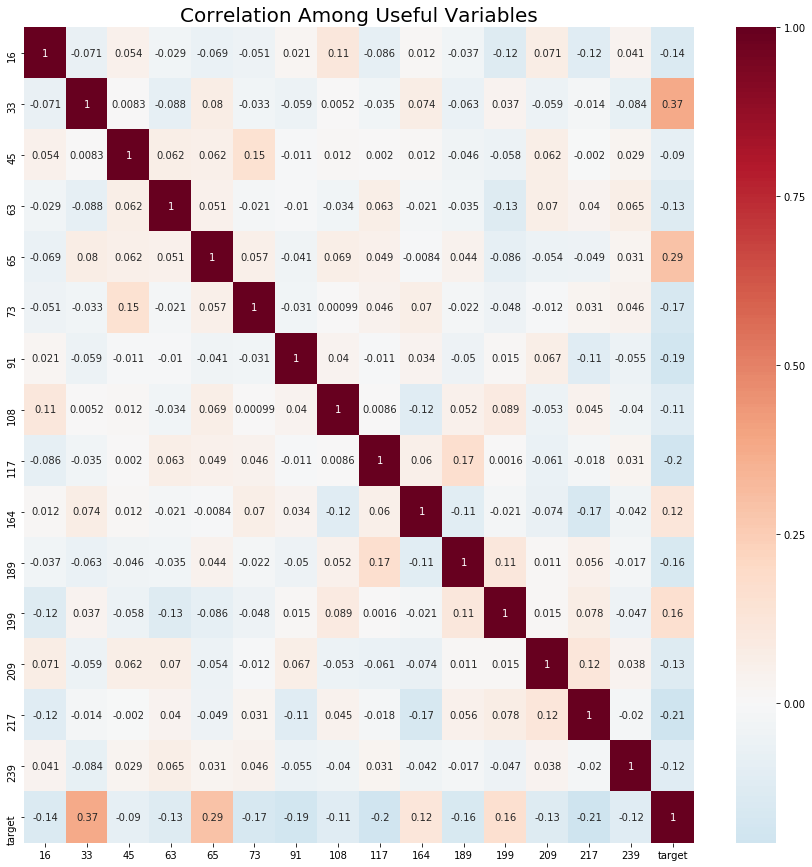

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

idx = df.loc[ df['A']!=0, 'var' ].values
idx = np.sort(idx); idx2 = []
for i in idx: idx2.append(str(i))

plt.figure(figsize=(15,15))
sns.heatmap(train[idx2+['target']].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('Correlation Among Useful Variables',fontsize=20)
plt.show()